# 1.) Import an asset price from Yahoo Finance

In [1]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 3.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [2]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


########################################
####Pick your ticker and time period####
########################################
stock_data = yf.download("^IRX", start="1990-01-01", end="2022-02-21")



# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)


# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]

[*********************100%***********************]  1 of 1 completed


# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly

In [4]:
import pandas as pd
import numpy as np


# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]

# Create x_train and y_train
window_size = 10
x_train = []
y_train = []
for i in range(window_size, len(train_data)-1):
    x_train.append(train_data[i-window_size:i, 0])
    y_train.append([1 if train_data[i+1, 0] > 0 else 0])

# Convert to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [5]:
x_train.shape

(6441, 10, 1)

In [6]:
###################################
####Build Your RNN Architecture####
###################################
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(x_train.shape[1], return_sequences=False, input_shape=(window_size, 1))),
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
model.summary()

model.fit(x_train, y_train, batch_size = 32, epochs = 10)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
202/202 [==============================] - 6s 11ms/step - loss: 0.6782 - accuracy: 0.5911
Epoch 2/10
202/202 [==============================] - 2s 11ms/step - loss: 0.6738 - accuracy: 0.5991
Epoch 3/10
202/202 [==============================] - 2s 10ms/step - loss: 0.6733 - accuracy: 0.5991
Epoch 4/10
202/202 [==============================] - 2s 12ms/step - loss: 0.6727 - accuracy: 0.5991
Epoch 5/10
202/202 [==============================

# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

OUT OF SAMPLE

Out of sample RMSE

In [22]:
test_data = scaled_data[training_data_len - window_size:, :]

x_test = []
y_test = np.empty((0,1))

for i in range(window_size, len(test_data)):
    x_test.append(test_data[i-window_size:i, 0])
    if test_data[i,0] > test_data[i-1,0]:
      y_test = np.concatenate((y_test, np.array([[1]])), axis = 0)
    else:
      y_test = np.concatenate((y_test, np.array([[0]])), axis = 0)

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = np.array(y_test)

predictions = model.predict(x_test)
predictions

51/51 [==============================] - 1s 3ms/step


array([[0.40044418],
       [0.39991793],
       [0.36110672],
       ...,
       [0.39579624],
       [0.40470874],
       [0.41152164]], dtype=float32)

In [23]:
y_test_binary = (y_test > 0.5).astype(int)
y_test_binary

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [24]:
predictions_bin = np.where(predictions > 0.5, 1, 0)
predictions_bin

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [22]:
predictions.shape

(1613, 1)

In [23]:
x_train.shape

(6441, 10, 1)

In [25]:
from sklearn.metrics import accuracy_score
in_sample_acc_rw = accuracy_score(y_train[1:], y_train[:-1])
out_sample_acc_rw = accuracy_score(y_test_binary[1:], y_test_binary[:-1])

In [26]:
in_sample_acc_rw

0.5385093167701863

In [27]:
out_sample_acc_rw

0.3529776674937965

In [29]:
y_train_pred = model.predict(x_train)
y_train_pred_binary = (y_train_pred > 0.5).astype(int)
in_sample_acc = accuracy_score(y_train[1:], y_train_pred_binary[:-1])

202/202 [==============================] - 2s 8ms/step


In [30]:
in_sample_acc

0.5990683229813665

In [31]:
y_test_pred = model.predict(x_test)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)
y_test_binary = (y_test > 0.5).astype(int)
out_sample_acc = accuracy_score(y_test_binary[1:], y_test_pred_binary[:-1])

51/51 [==============================] - 0s 6ms/step


In [32]:
out_sample_acc

0.5204714640198511

The mean squared error for out of sample performance is 0.35 while the RMSE for y_test is 0.004. Because this is lower, we can say that random walk outperforms the out of sample evaluation.

<BarContainer object of 4 artists>

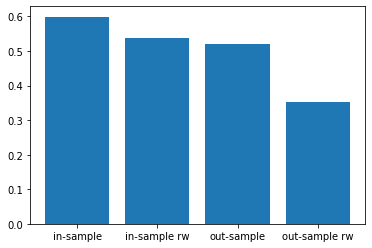

In [33]:
import matplotlib.pyplot as plt
plt.bar(["in-sample", "in-sample rw", "out-sample", "out-sample rw"], [in_sample_acc, in_sample_acc_rw, out_sample_acc, out_sample_acc_rw])

#5.) Write an observation/conclusion about the graphs from Q4 and Q3

From the above graph, we see the followin about the in-sample data:
1. The in-sample accuracy is higher as compared to in-sample random walk. Hence, we can say that in-sample accuracy outperforms the random walk. 
2. The out-sample accuracy is higher as compared to out-sample random walk. Hence, as with the in-sample accuracy, the out-sample accuracy out performs the random walk. 

# 6.) Create a parameter for number of lags in your input layer. Do a 3-fold CV to test three different time lags. i.e. Tested using 5,10,20 days of previous price data to forecast

In [41]:
KerasRegressor?

In [45]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor

# Define the Keras model
###Edit here to create your optimizer
from keras.layers import LSTM

def create_model(num_lags, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(10, input_shape=(num_lags, 1), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Wrap the Keras model in a scikit-learn compatible estimator
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the hyperparameters to search over
####EXAMPLE###
param_grid = {
              'batch_size': [10, 20, 100],
              'num_lags': [5, 10, 20],
              'epochs': [10, 100],
              'optimizer': ['adam', 'rmsprop']
}

# Perform the grid search over the hyperparameters

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

# Print the results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

<ipython-input-45-cf869337948c>:17: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)
/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
72 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the fo

Best: -0.688997 using {'batch_size': 20, 'epochs': 10, 'num_lags': 10, 'optimizer': 'rmsprop'}
